In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, r'C:\code\astrocam')
import importlib
import rawpy
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import fwhm.star_finder

In [2]:
pd.set_option("display.precision", 3)

In [3]:
from fwhm.star_finder import StarFinder

In [4]:
from pathlib import Path
import tempfile
import pickle

def load_stardata(fpath):
  fpath = Path(fpath)
  datafile = Path(tempfile.gettempdir()) / fpath.with_suffix('.stardata').name

  if datafile.exists():
    with datafile.open('rb') as f:
      starData = pickle.load(f)
      return starData

ref_data =  r"D:\Astro\20220922\C30\Light\Light_00935_180.0sec_200gain_-0.3C.fit"
tgt_data = r"D:\Astro\20220922\C30\Light\Light_00936_180.0sec_200gain_-0.3C.fit"

ref_data = load_stardata(ref_data)
tgt_data = load_stardata(tgt_data)
ref_image, df_ref = ref_data["image"], ref_data["stars"]
tgt_image, df_tgt = tgt_data["image"], tgt_data["stars"]

Scan stars from image

In [5]:
from pathlib import Path

root = Path(r"D:\Astro\astro-pre-2022\M94-120-2500iso\light")
out_of_focus = root / "Image009.nef"
in_focus = root / "Image035.nef"
in_focus_753 = root / "Image043.nef"

s = StarFinder()

ref_data = s.getStarData(in_focus)
tgt_data = s.getStarData(in_focus_753)
ref_image, df_ref = ref_data["image"], ref_data["stars"]
tgt_image, df_tgt = tgt_data["image"], tgt_data["stars"]


Calculating FWHM: 100%|██████████| 96/96 [00:00<00:00, 457.70it/s]


In [6]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y
0,302,3568.715,1796.235,19.001,17.001,18.224,19.853,"[3548, 1778, 3589, 1815]",677984,10696,81.816,73.273
1,288,1160.104,1646.226,17.001,18.001,19.282,18.547,"[1142, 1627, 1179, 1666]",621586,9675,54.303,54.881
2,277,2931.632,2325.437,17.001,17.001,18.325,18.227,"[2913, 2307, 2950, 2344]",876881,13889,80.613,80.035
3,249,1951.711,1243.614,15.001,17.001,18.446,16.495,"[1935, 1225, 1968, 1262]",469476,7432,73.038,77.637
4,248,4661.242,1940.008,17.001,14.001,15.185,18.844,"[4642, 1925, 4681, 1956]",732545,11675,59.582,49.532
5,230,5244.443,3600.161,15.001,17.001,18.349,16.661,"[5228, 3582, 5261, 3619]",1358511,21521,24.965,27.821
6,218,5066.023,1881.133,15.001,16.001,17.247,16.193,"[5050, 1864, 5083, 1899]",710027,11309,41.528,44.458
7,217,1955.037,1194.922,14.001,17.001,17.771,14.960,"[1940, 1177, 1971, 1212]",451381,7054,70.094,76.209
8,203,5659.424,821.803,14.001,16.001,17.875,15.446,"[5644, 804, 5675, 839]",310555,5091,18.450,21.615
9,200,5887.945,1100.290,14.001,14.001,15.379,15.673,"[5872, 1085, 5903, 1116]",416172,6610,20.236,18.433


In [7]:
df_ref

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y
0,289,1157.190,1651.003,18.001,18.001,18.641,18.432,"[1139, 1632, 1176, 1671]",623093,9864,55.452,55.760
1,265,3565.709,1800.083,17.001,16.001,17.278,17.737,"[3547, 1783, 3584, 1818]",679491,10695,75.138,67.776
2,261,2928.747,2329.739,17.001,16.001,17.316,18.188,"[2910, 2312, 2947, 2347]",878388,13889,81.509,77.418
3,252,1948.774,1247.262,16.001,16.001,17.563,17.332,"[1931, 1230, 1966, 1265]",470983,7432,78.932,78.144
4,233,4657.940,1943.918,16.001,14.001,15.952,18.423,"[4639, 1928, 4676, 1959]",734052,11675,56.884,50.726
5,218,5656.523,826.014,13.001,18.001,18.989,14.560,"[5642, 807, 5671, 846]",313570,5091,18.163,23.373
6,208,5063.173,1885.562,15.001,15.001,16.411,16.238,"[5047, 1869, 5080, 1902]",711534,11309,40.568,42.044
7,202,4249.564,2544.188,16.001,13.001,14.337,17.304,"[4232, 2530, 4267, 2559]",960150,15253,72.427,60.839
8,199,1951.236,1198.558,14.001,15.001,16.670,15.475,"[1936, 1182, 1967, 1215]",452888,7054,68.891,73.357
9,198,4328.904,1518.990,15.001,14.001,15.891,16.053,"[4312, 1503, 4345, 1534]",574122,9018,65.951,62.289


Make triangles with stars as vertices
- For each triangle, store the ratio of two shorter sides to the longest side as fX & fY

In [8]:
from itertools import combinations, product
import math

def getTriangles(df):

    # Cache distances between every pair of stars
    starDistances = {}
    for c in combinations(df.index, 2):
        assert(c[1] > c[0])
        key = (c[0], c[1])
        x1, y1 = df.loc[c[0],['cluster_cx', 'cluster_cy']]
        x2, y2 = df.loc[c[1],['cluster_cx', 'cluster_cy']]
        starDistances[key] = math.sqrt((x2-x1)**2 + (y2-y1)**2)

    vTriangles = []
    for i,j,k in combinations(df.index, 3):
        vDistances = sorted([starDistances[(i,j)], starDistances[(j,k)], starDistances[(i,k)]])

        if vDistances[2] > 0:
            fX = vDistances[1]/vDistances[2]
            fY = vDistances[0]/vDistances[2]

            # Filter
            if (fX < 0.9):
                # Add to the triangle list
                vTriangles.append({"s1":i, "s2":j, "s3":k, "fX":fX, "fY":fY})

    vTriangles = sorted(vTriangles, key=lambda x: x["fX"])
    return pd.DataFrame(vTriangles)


In [9]:
tri_ref = getTriangles(df_ref)
print(len(tri_ref))

879


In [10]:
tri_tgt = getTriangles(df_tgt)
print(len(tri_tgt))

894


Collect triangle match counts

In [11]:
TRIANGLETOLERANCE = 1e-4
votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.uint32)

for tgt in tri_tgt.itertuples():
    ref_matches = tri_ref[(tri_ref.fX >= tgt.fX) & (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE)]
    ref_matches = ref_matches[(ref_matches.fX-tgt.fX)**2 + (ref_matches.fY-tgt.fY)**2 < TRIANGLETOLERANCE**2]
    for ref in ref_matches.itertuples():
        for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
            votes[int(a), b] += 1

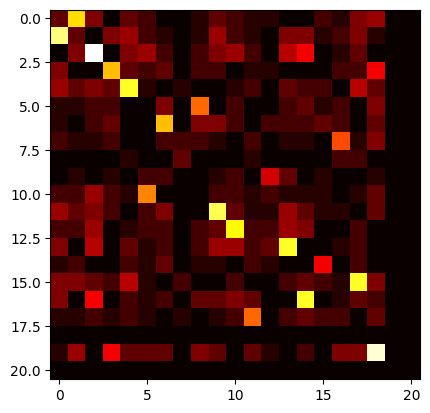

In [12]:
plt.imshow(votes, cmap='hot')
plt.show()

Produce sorted list of star pairs with highest votes

In [13]:
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [14]:
len(vVotingPairs)

441

Select only those votes that are higher than a treshold

In [15]:
x,y = vVotingPairs[len(df_tgt)]
cutoff = max(1, votes[x,y])
print(f"Vote cutoff threshold: {cutoff}")
topVotePairs = list(filter(lambda r: votes[r[0],r[1]] > cutoff, vVotingPairs))

Vote cutoff threshold: 8


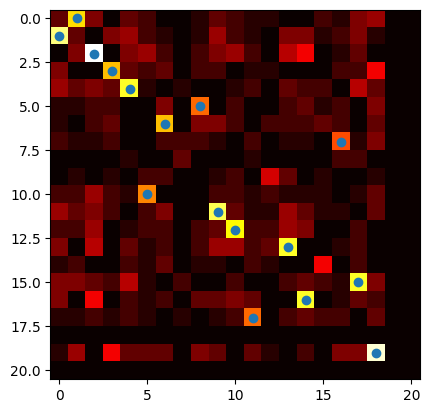

In [16]:
plt.imshow(votes, cmap='hot')
plt.scatter([x[1] for x in topVotePairs], [x[0] for x in topVotePairs])
plt.show()

In [17]:
len(topVotePairs)

16

In [18]:
matches = []
for vp in topVotePairs:
    s1, s2 = vp
    if s1 == 0 or s2 == 0:
        continue
    if np.argmax(votes[:, s2]) != s1 or np.argmax(votes[s1, :]) != s2:
        continue
    matches.append((s1, s2))

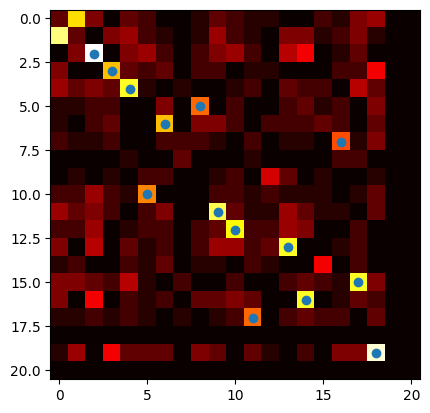

In [19]:
plt.imshow(votes, cmap='hot')
plt.scatter([x[1] for x in matches], [x[0] for x in matches])
plt.show()

Plot star match results

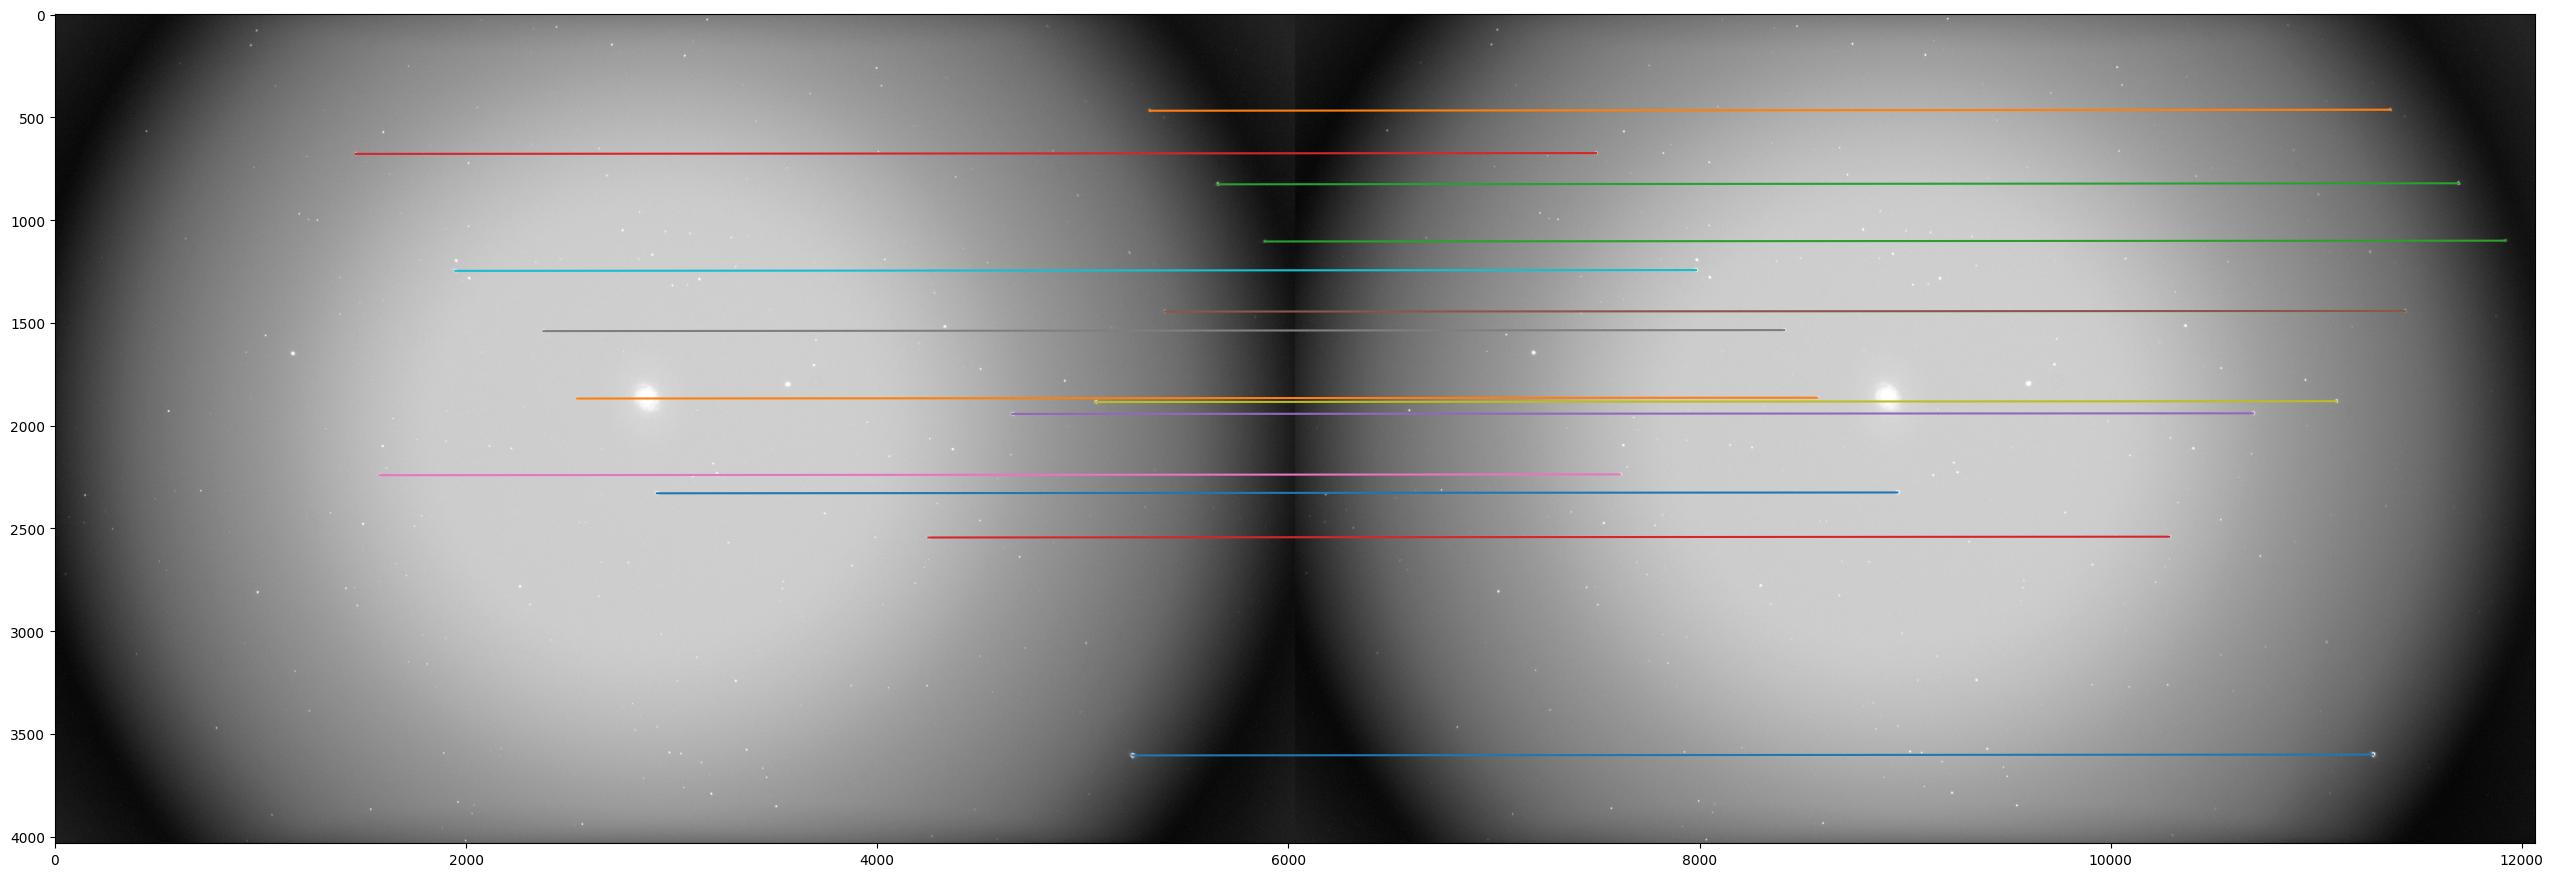

In [20]:
img = np.column_stack((ref_image,tgt_image))
fig = plt.figure(figsize=(32,16))
plt.imshow(img, cmap='gray')

for s1,s2 in matches:
    x1,y1 = df_ref.loc[s1, ['cluster_cx', 'cluster_cy']]
    x2,y2 = df_tgt.loc[s2, ['cluster_cx', 'cluster_cy']]
    x2 += ref_image.shape[1]
    xs = [int(x1), int(x2)]
    ys = [int(y1), int(y2)]
    plt.plot(xs, ys)

plt.show()

In [21]:
df_ref

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y
0,289,1157.190,1651.003,18.001,18.001,18.641,18.432,"[1139, 1632, 1176, 1671]",623093,9864,55.452,55.760
1,265,3565.709,1800.083,17.001,16.001,17.278,17.737,"[3547, 1783, 3584, 1818]",679491,10695,75.138,67.776
2,261,2928.747,2329.739,17.001,16.001,17.316,18.188,"[2910, 2312, 2947, 2347]",878388,13889,81.509,77.418
3,252,1948.774,1247.262,16.001,16.001,17.563,17.332,"[1931, 1230, 1966, 1265]",470983,7432,78.932,78.144
4,233,4657.940,1943.918,16.001,14.001,15.952,18.423,"[4639, 1928, 4676, 1959]",734052,11675,56.884,50.726
5,218,5656.523,826.014,13.001,18.001,18.989,14.560,"[5642, 807, 5671, 846]",313570,5091,18.163,23.373
6,208,5063.173,1885.562,15.001,15.001,16.411,16.238,"[5047, 1869, 5080, 1902]",711534,11309,40.568,42.044
7,202,4249.564,2544.188,16.001,13.001,14.337,17.304,"[4232, 2530, 4267, 2559]",960150,15253,72.427,60.839
8,199,1951.236,1198.558,14.001,15.001,16.670,15.475,"[1936, 1182, 1967, 1215]",452888,7054,68.891,73.357
9,198,4328.904,1518.990,15.001,14.001,15.891,16.053,"[4312, 1503, 4345, 1534]",574122,9018,65.951,62.289


In [22]:
matches

[(2, 2),
 (19, 18),
 (11, 9),
 (13, 13),
 (4, 4),
 (15, 17),
 (16, 14),
 (12, 10),
 (6, 6),
 (3, 3),
 (10, 5),
 (17, 11),
 (5, 8),
 (7, 16)]

In [23]:
df_tgt['starno'] = None
for m1, m2 in matches:
  df_tgt.loc[m2, 'starno'] = m1

In [33]:
frames = pd.merge(left=df_ref,
                  right=df_tgt[df_tgt.starno.notna()],
                  left_index=True,
                  right_on='starno',
                  how='right',
                  suffixes=["_ref", "_tgt"])

In [34]:
frames

,area_ref,cluster_cx_ref,cluster_cy_ref,iwc_cx_ref,iwc_cy_ref,gaussian_cx_ref,gaussian_cy_ref,box_ref,tile_4_ref,tile_32_ref,...,iwc_cx_tgt,iwc_cy_tgt,gaussian_cx_tgt,gaussian_cy_tgt,box_tgt,tile_4_tgt,tile_32_tgt,fwhm_x_tgt,fwhm_y_tgt,starno
2,261,2928.747,2329.739,17.001,16.001,17.316,18.188,"[2910, 2312, 2947, 2347]",878388,13889,...,17.001,17.001,18.325,18.227,"[2913, 2307, 2950, 2344]",876881,13889,80.613,80.035,2
3,252,1948.774,1247.262,16.001,16.001,17.563,17.332,"[1931, 1230, 1966, 1265]",470983,7432,...,15.001,17.001,18.446,16.495,"[1935, 1225, 1968, 1262]",469476,7432,73.038,77.637,3
4,233,4657.940,1943.918,16.001,14.001,15.952,18.423,"[4639, 1928, 4676, 1959]",734052,11675,...,17.001,14.001,15.185,18.844,"[4642, 1925, 4681, 1956]",732545,11675,59.582,49.532,4
5,198,5241.924,3604.379,14.001,15.001,16.914,15.766,"[5226, 3588, 5257, 3621]",1360018,21521,...,15.001,17.001,18.349,16.661,"[5228, 3582, 5261, 3619]",1358511,21521,24.965,27.821,10
6,208,5063.173,1885.562,15.001,15.001,16.411,16.238,"[5047, 1869, 5080, 1902]",711534,11309,...,15.001,16.001,17.247,16.193,"[5050, 1864, 5083, 1899]",710027,11309,41.528,44.458,6
8,218,5656.523,826.014,13.001,18.001,18.989,14.560,"[5642, 807, 5671, 846]",313570,5091,...,14.001,16.001,17.875,15.446,"[5644, 804, 5675, 839]",310555,5091,18.450,21.615,5
9,194,5885.026,1104.108,14.001,14.001,15.369,14.723,"[5870, 1089, 5901, 1120]",417679,6799,...,14.001,14.001,15.379,15.673,"[5872, 1085, 5903, 1116]",416172,6610,20.236,18.433,11
10,188,2377.989,1540.106,14.001,14.001,15.173,15.471,"[2362, 1525, 2393, 1556]",581174,9146,...,13.001,14.001,15.456,14.611,"[2366, 1520, 2395, 1551]",579667,9146,67.888,70.499,12
11,158,5325.905,468.063,12.001,14.001,15.046,13.427,"[5312, 453, 5339, 484]",177767,3001,...,12.001,16.001,17.796,12.675,"[5316, 446, 5343, 481]",176260,2813,27.386,34.081,17
13,173,1462.439,678.462,13.001,13.001,14.442,14.203,"[1448, 664, 1477, 693]",256726,4015,...,12.001,15.001,15.599,13.376,"[1452, 659, 1479, 690]",255218,4015,38.917,45.076,13


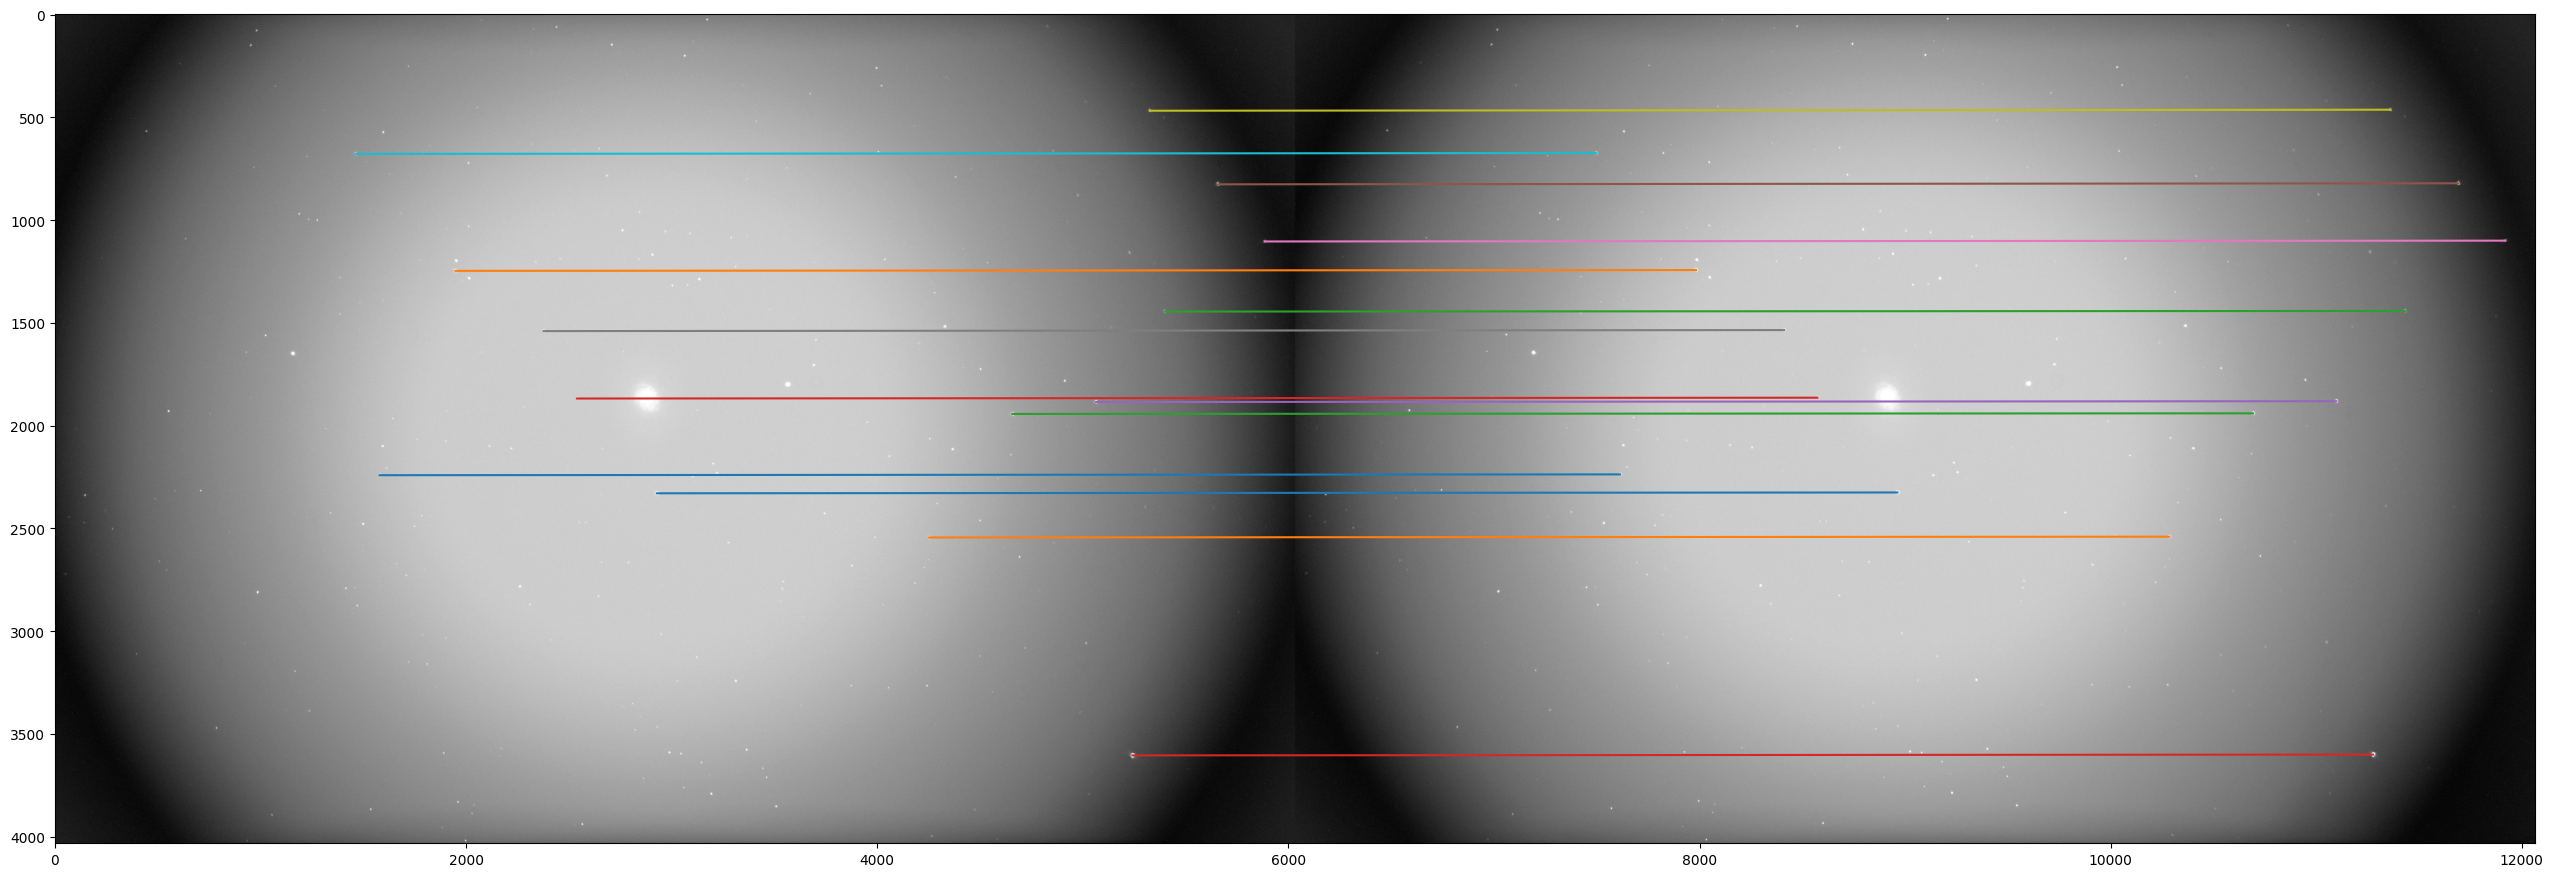

In [35]:
img = np.column_stack((ref_image,tgt_image))
fig = plt.figure(figsize=(32,16))
plt.imshow(img, cmap='gray')

for key, row in frames.iterrows():
    x1,y1 = row.cluster_cx_ref, row.cluster_cy_ref
    x2,y2 = row.cluster_cx_tgt, row.cluster_cy_tgt
    x2 += ref_image.shape[1]
    xs = [int(x1), int(x2)]
    ys = [int(y1), int(y2)]
    plt.plot(xs, ys)

plt.show()

In [36]:
frames['fwhm_x_diff'] = frames.fwhm_x_ref - frames.fwhm_x_tgt
frames['fwhm_y_diff'] = frames.fwhm_y_ref - frames.fwhm_y_tgt

In [37]:
frames.head()

,area_ref,cluster_cx_ref,cluster_cy_ref,iwc_cx_ref,iwc_cy_ref,gaussian_cx_ref,gaussian_cy_ref,box_ref,tile_4_ref,tile_32_ref,...,gaussian_cx_tgt,gaussian_cy_tgt,box_tgt,tile_4_tgt,tile_32_tgt,fwhm_x_tgt,fwhm_y_tgt,starno,fwhm_x_diff,fwhm_y_diff
2,261,2928.747,2329.739,17.001,16.001,17.316,18.188,"[2910, 2312, 2947, 2347]",878388,13889,...,18.325,18.227,"[2913, 2307, 2950, 2344]",876881,13889,80.613,80.035,2,0.897,-2.617
3,252,1948.774,1247.262,16.001,16.001,17.563,17.332,"[1931, 1230, 1966, 1265]",470983,7432,...,18.446,16.495,"[1935, 1225, 1968, 1262]",469476,7432,73.038,77.637,3,5.894,0.507
4,233,4657.940,1943.918,16.001,14.001,15.952,18.423,"[4639, 1928, 4676, 1959]",734052,11675,...,15.185,18.844,"[4642, 1925, 4681, 1956]",732545,11675,59.582,49.532,4,-2.698,1.194
5,198,5241.924,3604.379,14.001,15.001,16.914,15.766,"[5226, 3588, 5257, 3621]",1360018,21521,...,18.349,16.661,"[5228, 3582, 5261, 3619]",1358511,21521,24.965,27.821,10,-0.989,-0.887
6,208,5063.173,1885.562,15.001,15.001,16.411,16.238,"[5047, 1869, 5080, 1902]",711534,11309,...,17.247,16.193,"[5050, 1864, 5083, 1899]",710027,11309,41.528,44.458,6,-0.961,-2.414


In [38]:
frames.fwhm_x_diff.mean(), frames.fwhm_y_diff.mean()

(1.456014354990445, 1.024474717784164)

In [39]:
frames.fwhm_x_diff.std(), frames.fwhm_y_diff.std()

(5.942431205286079, 5.065429677522868)